In [1]:
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [2]:
from scipy import optimize

## Data

In [3]:
raw_health = Table.read_table('e13.csv')

In [4]:
pounds_per_kilogram = 2.204623
inches_per_meter = 39.3700787
dims = raw_health.select(['r8heightbio', 'r8weightbio', 'r8agey_m', 'r8smoken', 'ragender'])
dims['height'] = np.round(dims['r8heightbio'] * inches_per_meter, 3)
dims['weight'] = np.round(dims['r8weightbio'] * pounds_per_kilogram, 3)
dims.relabel('r8agey_m', 'age')
dims.relabel('r8smoken', 'smokes')
dims['gender'] = dims['ragender'] - 1
dims = dims.select(['height', 'weight', 'age', 'smokes', 'gender'])
dims

height | weight | age  | smokes | gender
64.75  | 163.5  | 70   | 0      | 0
63.75  | 147.5  | 67   | 0      | 1
61     | 142    | 50   | 0      | 1
72.5   | 224    | 66   | 0      | 0
64.5   | 170.5  | 60   | 0      | 1
68     | 243    | 68   | 0      | 0
67.25  | 162    | 70   | 0      | 0
65.75  | 144    | 63   | 0      | 1
62.5   | 167.5  | 64   | 0      | 1
65.5   | 130    | 70   | 1      | 1
... (6332 rows omitted)

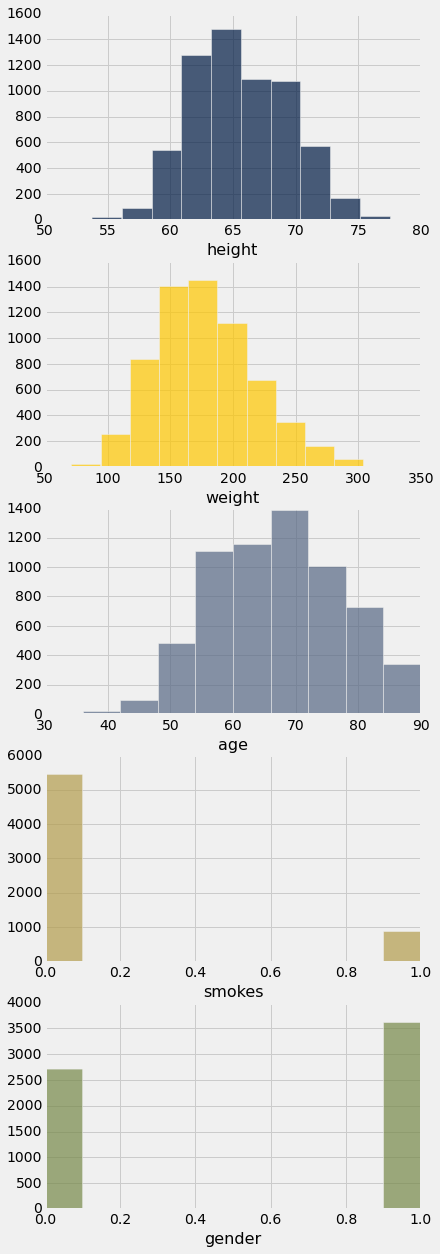

In [5]:
dims.hist()

In [6]:
hw = list(zip(dims['height'], dims['weight']))
hw[:5]

[(64.75, 163.5), (63.75, 147.5), (61.0, 142.0), (72.5, 224.0), (64.5, 170.5)]

## Prediction 

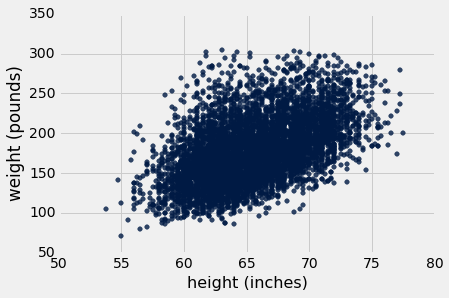

In [7]:
dims.select(['height', 'weight']).scatter('height')
plots.xlabel('height (inches)')
plots.ylabel('weight (pounds)')

In [8]:
def root_mean_squared_error(f, pairs):
    return np.sqrt(np.average([(y-f(x))**2 for x, y in pairs]))

In [9]:
def lookup_predictor(pairs):
    index = {x: y for x, y in pairs}
    def f(x):
        return index[x]
    return f

In [10]:
def evaluate(f):
    print('f(60): ', f(60))
    print('f(72): ', f(72))
    print('error: ', round(root_mean_squared_error(f, hw), 3))

In [11]:
f = lookup_predictor(hw)
evaluate(f)

f(60):  113.0
f(72):  243.5
error:  45.103


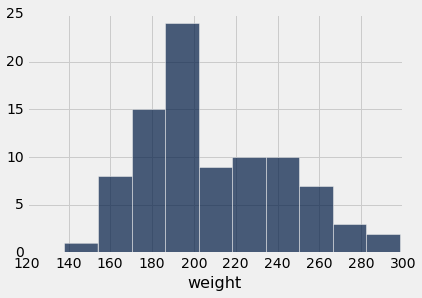

In [12]:
dims.where('height', 72).select('weight').hist()

In [13]:
def average_predictor(pairs):
    xs = set([x for x, _ in pairs])
    index = {x: np.average([y for xa, y in pairs if xa == x]) for x, _ in pairs}
    def f(x):
        return index[x]
    return f
f = average_predictor(hw)
evaluate(f)

f(60):  152.97029703
f(72):  209.438202247
error:  33.652


## Linear Regression

In [14]:
def linear_predictor(params):
    slope, intercept = params
    def f(x):
        return slope * x + intercept
    return f

In [15]:
f = linear_predictor([5, -150])
evaluate(f)

f(60):  150
f(72):  210
error:  33.914


In [16]:
def best_linear_predictor(pairs):
    def objective(params):
        f = linear_predictor(params)
        return root_mean_squared_error(f, pairs)
    optimum = optimize.minimize(objective, [1, 1])
    params = optimum['x']
    print('params:', params)
    return linear_predictor(params)

f = best_linear_predictor(hw)
evaluate(f)

params: [   5.07699922 -154.98641853]
f(60):  149.633534584
f(72):  210.557525206
error:  33.912


## Multiple Regression

In [17]:
data = [((height, age, smokes, gender), weight) for height, weight, age, smokes, gender in dims.rows]
data[:5]

[((64.75, 70, 0, 0), 163.5),
 ((63.75, 67, 0, 1), 147.5),
 ((61.0, 50, 0, 1), 142.0),
 ((72.5, 66, 0, 0), 224.0),
 ((64.5, 60, 0, 1), 170.5)]

In [18]:
def multiple_predictor(params):
    def f(xs):
        return sum([p*x for p, x in zip(params[:-1], xs)]) + params[-1]
    return f

In [19]:
f = multiple_predictor([5, 0, -10, 0, -150])
root_mean_squared_error(f, data)

33.694403885525013

In [20]:
def best_multiple_predictor(pairs):
    def objective(params):
        f = multiple_predictor(params)
        return root_mean_squared_error(f, pairs)
    k = len(pairs[0][0]) + 1
    optimum = optimize.minimize(objective, [1] * k)
    params = optimum['x']
    print('params:', params)
    return multiple_predictor(params)

In [21]:
f = best_multiple_predictor(data)
root_mean_squared_error(f, data)

params: [  4.25284501  -0.58198152 -15.03172545  -7.55433893 -55.69606991]


33.132575141501881

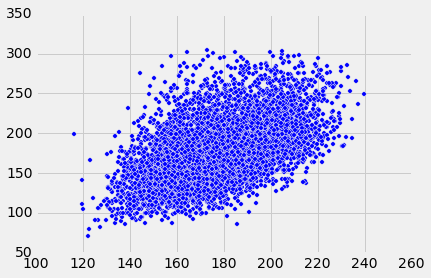

In [22]:
plots.scatter([f(x) for x, _ in data], [y for _, y in data])

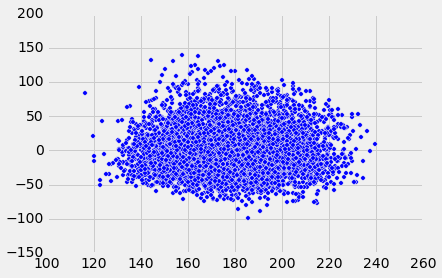

In [23]:
plots.scatter([f(x) for x, y in data], [y-f(x) for x, y in data])

## Classification

In [24]:
data = [((height, age, smokes, weight), gender) for height, weight, age, smokes, gender in dims.rows]
len([y for x, y in data if y==1])/len(data)

0.5723746452223274

In [25]:
def choice(f):
    return lambda x: 1 if f(x) >= 0.5 else 0
def accuracy(f, pairs):
    return len([y for x, y in pairs if y==f(x)]) / len(pairs)

In [26]:
f = best_multiple_predictor(data)
accuracy(choice(f), data)

params: [ -9.13460788e-02  -6.48244704e-03  -2.67523908e-02  -7.72545110e-04
   7.13248666e+00]


0.869914853358562

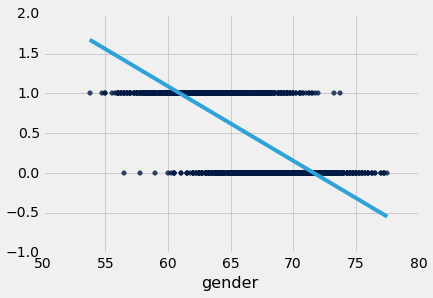

In [27]:
dims.select(['gender', 'height']).scatter('height', fit_line=True)

In [28]:
from sklearn.svm import SVC 
X = np.column_stack(dims.columns[0:-1])
y = [row[-1] for row in dims.rows]
c = SVC(kernel='linear')
c.fit(X, y)
c.score(X, y)

0.87038789025543994

In [29]:
from sklearn.linear_model import LogisticRegression
c = LogisticRegression(C=100)
c.fit(X, y)
c.score(X, y)

0.87023021128981393

## Generalization

In [30]:
half = len(data)//2
first, second = data[:half], data[half:]

In [31]:
f = best_multiple_predictor(first)
accuracy(choice(f), first)

params: [ -8.97517359e-02  -1.41221884e-02  -1.09975942e-02  -7.23644211e-04
   7.53716754e+00]


0.8795332702617471

In [32]:
accuracy(choice(f), second)

0.8435824660990224

In [33]:
c = LogisticRegression(C=100)
c.fit(X[half:], y[half:])
c.score(X[:half], y[:half])

0.87007253232418791

## Language Models

In [34]:
shakes = open('shakespeare.txt')
text = shakes.read().split()
len(text)

980637

In [35]:
from collections import Counter

counts = {}
first, second = (text[1000], text[1001])
for third in text[1002:]:
    context = (first, second)
    if context not in counts:
        counts[context] = Counter()
    if second not in counts:
        counts[second] = Counter()
    counts[context][third] += 1
    counts[second][third] += 1
    first, second = second, third

In [36]:
from random import randrange
from itertools import islice

def sample_next(context):
    c = counts[context]
    i = randrange(sum(c.values()))    
    return next(islice(c.elements(), i, None))

In [37]:
def sample_sentence():
    prev = sample_next('.')
    word = sample_next(('.', prev))
    words = [prev, word]
    while word not in ('.', '?', '!'):
        prev, word = word, sample_next((prev, word))
        words.append(word)
    return ' '.join(words)

for _ in range(5):
    print(sample_sentence())
    print()

With all the rest That fell away have entertainment , your passes , stoccadoes , and she loveth him , with over-measure .

Unless you be ?

Nay , that , And bind us further to mine own tears Do scald like molten lead .

We were dissuaded by our meeds , Should be past .

Good sometime queen , up to shame it .



In [38]:
shake_data = [((first, second), third) for first, second, third in zip(text[:-2], text[1:-1], text[2:])]
shake_data[:10]

[(('A', "MIDSUMMER-NIGHT'S"), 'DREAM'),
 (("MIDSUMMER-NIGHT'S", 'DREAM'), 'Now'),
 (('DREAM', 'Now'), ','),
 (('Now', ','), 'fair'),
 ((',', 'fair'), 'Hippolyta'),
 (('fair', 'Hippolyta'), ','),
 (('Hippolyta', ','), 'our'),
 ((',', 'our'), 'nuptial'),
 (('our', 'nuptial'), 'hour'),
 (('nuptial', 'hour'), 'Draws')]

In [39]:
def f(context):
    if context in counts:
        return counts[context].most_common(1)[0][0]
    elif context[1] in counts:
        return counts[context[1]].most_common(1)[0][0]
    else:
        return '.'
accuracy(f, shake_data[:1000])

0.13

In [40]:
accuracy(f, shake_data[2000:3000])

0.417